### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

### Read and Prepare Data

In [5]:
df = pd.read_csv("C:\\Users\\user\\OneDrive\\Desktop\\Project\\city_day.csv")
delhi = df[df['City'] == 'Delhi']

In [7]:
delhi['Date'] = pd.to_datetime(delhi['Date'])
delhi.set_index('Date', inplace = True)

In [9]:
delhi.head()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
Date,,,,,,,,,,,,,,,
2015-01-01,Delhi,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe
2015-01-02,Delhi,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0,Severe
2015-01-03,Delhi,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0,Moderate
2015-01-04,Delhi,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0,Very Poor
2015-01-05,Delhi,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0,Very Poor


#### Check for missing values

In [12]:
pm25 = delhi['PM2.5']
pm25[pm25.isna()]

Date
2017-08-12   NaN
2017-08-13   NaN
Name: PM2.5, dtype: float64

In [14]:
# filling the missing values with linear interpolation method
pm25 = pm25.interpolate(method = 'linear')

### Plotting the Data

<Axes: title={'center': 'PM 2.5'}, xlabel='Date'>

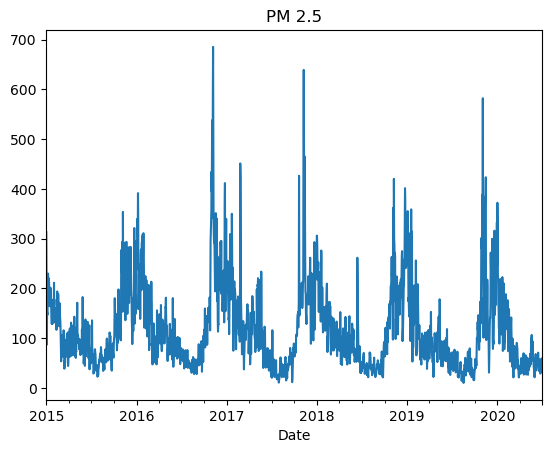

In [17]:
pm25.plot(title = 'PM 2.5')

#### ACF and PACF Plot

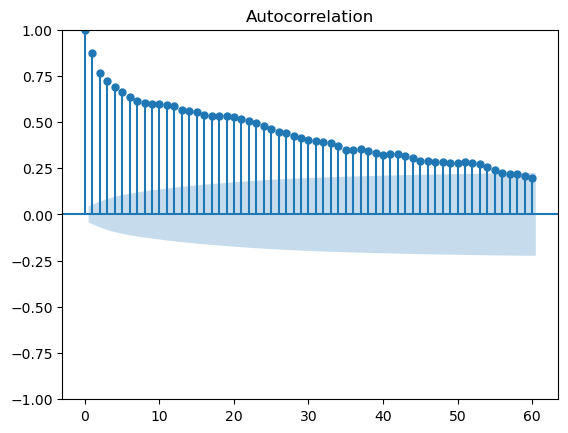

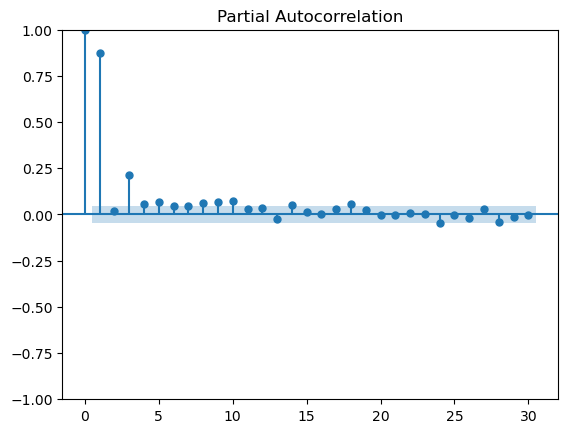

In [20]:
pm25_acf = plot_acf(pm25, lags = 60)
pm25_pacf = plot_pacf(pm25, lags = 30)

From the above plots, it can be seen that ACF is gradually falling off with the PACF falling off completely after a few lags indicating an AR process.
Possible orders for an AR model :- p = (1,3,5,10)

### Train-Test Split

In [24]:
train_pm25 = pm25[pm25.index < '2019-01-01']
test_pm25 = pm25[pm25.index >= '2019-01-01']

### Model Fitting

In [27]:
# Checking and comparing accuracy of the model with different possible orders

ps = [1,3,5,10]
for p in ps:
    model = ARIMA(train_pm25, order = (p,0,0)).fit()
    
    predicted = model.predict(start = '2019-01-01', end = '2019-03-01')
    actual = test_pm25[test_pm25.index <= '2019-03-01']
    rmse = ((actual - predicted)**2).mean()**0.5
    mae = abs(actual - predicted).mean()
    print('p = {}, AIC = {}, BIC = {}, Log Livelihood = {}, RMSE = {}, MAE = {}'.format(p, model.aic, model.bic, model.llf, rmse, mae))

p = 1, AIC = 14954.348502174324, BIC = 14970.209131409576, Log Livelihood = -7474.174251087162, RMSE = 68.29758621142291, MAE = 52.344893415080676
p = 3, AIC = 14868.848904167926, BIC = 14895.283286226679, Log Livelihood = -7429.424452083963, RMSE = 63.390975332842594, MAE = 52.294141990986965
p = 5, AIC = 14857.232168108876, BIC = 14894.240302991131, Log Livelihood = -7421.616084054438, RMSE = 63.88501852143921, MAE = 54.28728557342916
p = 10, AIC = 14844.156755141354, BIC = 14907.599272082361, Log Livelihood = -7410.078377570677, RMSE = 75.86552866929638, MAE = 65.35324905353842


Comparing the above parameters of different models, we choose the AR Model of order 3

In [30]:
model = ARIMA(train_pm25, order = (3,0,0)).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1461
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -7429.424
Date:                Tue, 13 May 2025   AIC                          14868.849
Time:                        00:06:03   BIC                          14895.283
Sample:                    01-01-2015   HQIC                         14878.710
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.8733     15.203      8.148      0.000      94.075     153.671
ar.L1          0.8591      0.014     62.641      0.000       0.832       0.886
ar.L2         -0.1937      0.021     -9.198      0.0

### Prediction

#### Actual vs Prediction Plot

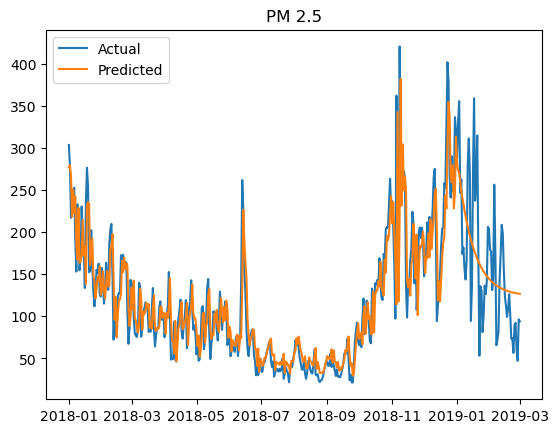

In [34]:
plt.plot(pm25[(pm25.index >= '2018-01-01') & (pm25.index <= '2019-03-01')], label = 'Actual')
plt.plot(model.predict(start = '2018-01-01', end = '2019-03-01'), label = 'Predicted')
plt.title('PM 2.5')
plt.legend()

#### MAE and RMSE on test data

In [37]:
predicted = model.predict(start = '2019-01-01', end = '2019-03-01')
actual = test_pm25[test_pm25.index <= '2019-03-01']
mae = abs(actual - predicted).mean()
rmse = ((actual - predicted)**2).mean()**0.5
print('MAE = {}, RMSE = {}'.format(mae, rmse))

MAE = 52.294141990986965, RMSE = 63.390975332842594


### Residuals

#### Density plot of Residuals

<Axes: ylabel='Density'>

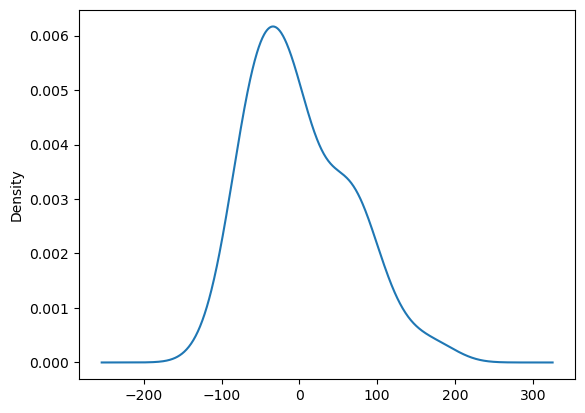

In [41]:
residuals = actual - predicted
residuals.plot(kind = 'kde')

#### ACF and PACF Plot of Residuals

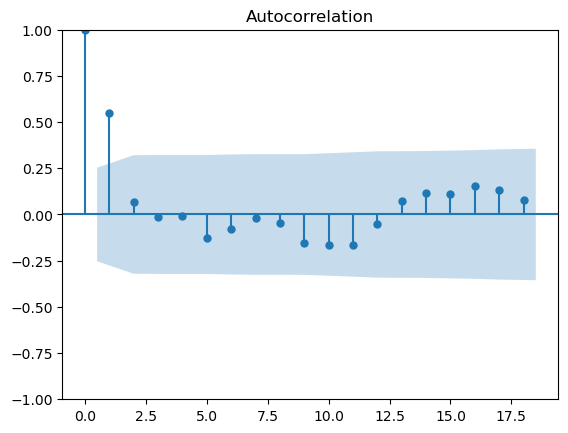

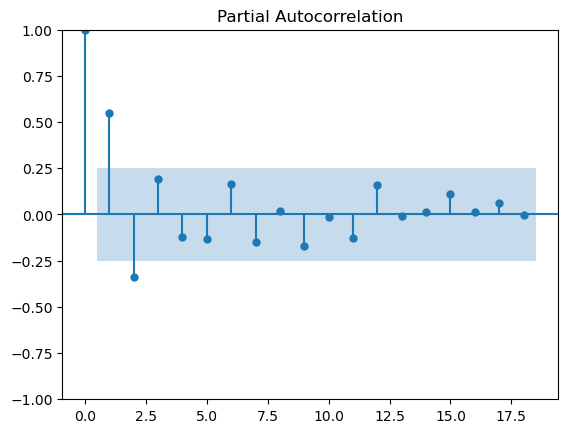

In [44]:
res_acf = plot_acf(residuals)
res_pacf = plot_pacf(residuals)

From the density plot it seems that the residuals follows a normal distribution but not too accurately indicating the model didn't quite capture the data. Further the ACF and PACF plot shows correlation between residuals suggesting the model missed some important patterns and trends and is too simple.

### Converting the daily data into a monthly data

In [47]:
pm25m = delhi['PM2.5'].resample(rule = 'MS').mean()
pm25m

Date
2015-01-01    175.690645
2015-02-01    153.920357
2015-03-01     80.338065
2015-04-01     91.562333
2015-05-01     97.109355
                 ...    
2020-03-01     57.506452
2020-04-01     44.940000
2020-05-01     55.448710
2020-06-01     46.694667
2020-07-01     54.010000
Freq: MS, Name: PM2.5, Length: 67, dtype: float64

<Axes: title={'center': 'PM 2.5'}, xlabel='Date'>

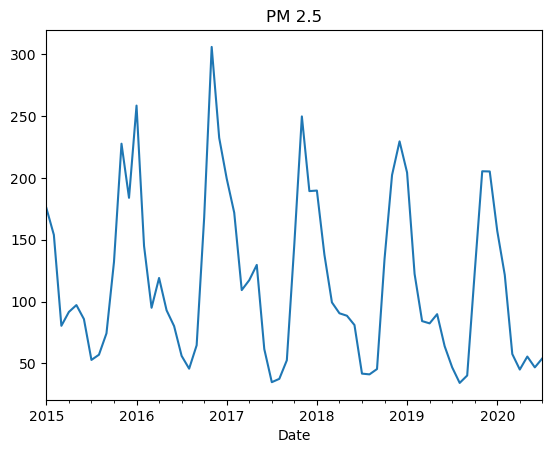

In [49]:
pm25m.plot(title = 'PM 2.5')

The data clearly doesn't show any trend but indeed has a visible seasonality. So, we use the **adfuller test** to check for stationarity of the series. 

#### Check for stationarity

In [53]:
pm25m_result = adfuller(pm25m)
print('Test Statistic: {}'.format(pm25m_result[0]))
print('p value: {}'.format(pm25m_result[1]))

Test Statistic: 0.1051175256024009
p value: 0.966408759417222


The p value is 0.966 > 0.05, which indicates that there is very weak evidence to reject the null hypothesis and the series is not stationary. So we compute the first order differences of the data and check again for stationarity. 

<Axes: xlabel='Date'>

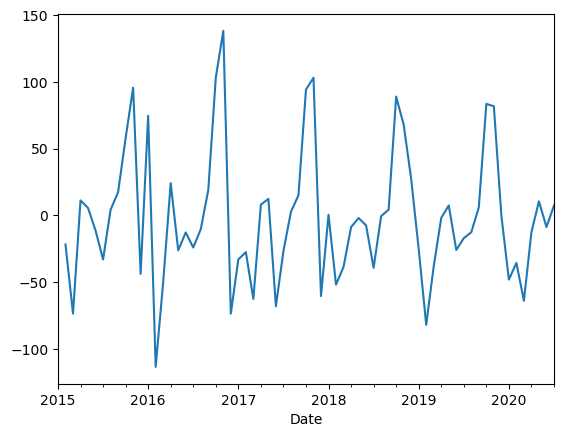

In [58]:
pm25m_diff1 = pm25m - pm25m.shift(1)
pm25m_diff1.plot()

In [60]:
pm25m_result2 = adfuller(pm25m_diff1.dropna())
print('Test Statistic: {}'.format(pm25m_result2[0]))
print('p value: {}'.format(pm25m_result2[1]))

Test Statistic: -7.71642271845219
p value: 1.2248286849539635e-11


Here the p value is very very smaller than 0.05 indicating a very strong evidence against the null hypothesis. So we conclude that the first order differences are stationary.

#### ACF and PACF plot of seasonal data

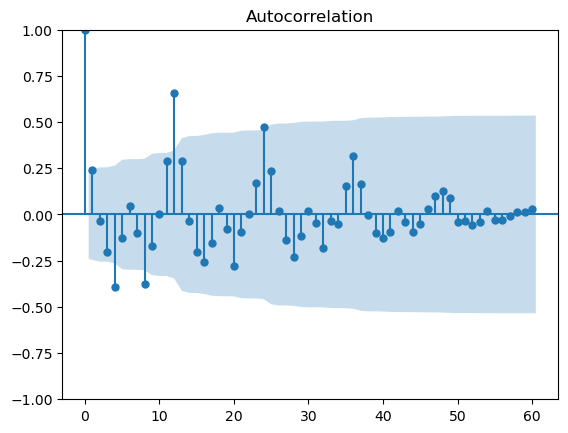

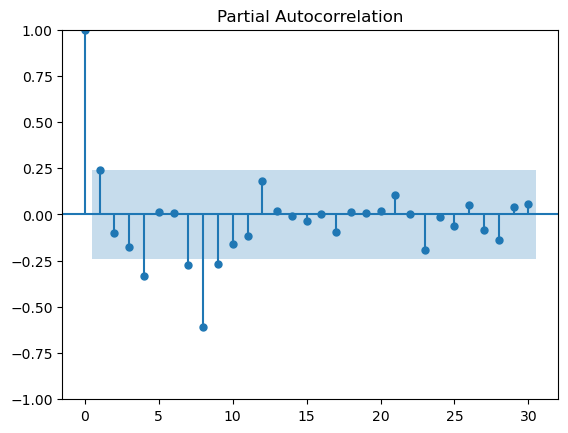

In [66]:
pm25m_diff1_acf = plot_acf(pm25m_diff1.dropna(), lags = 60)
pm25m_diff1_pacf = plot_pacf(pm25m_diff1.dropna(), lags = 30)

#### Seasonal difference

Now we take a difference of 12 steps to remove the seasonality from the the data

<Axes: xlabel='Date'>

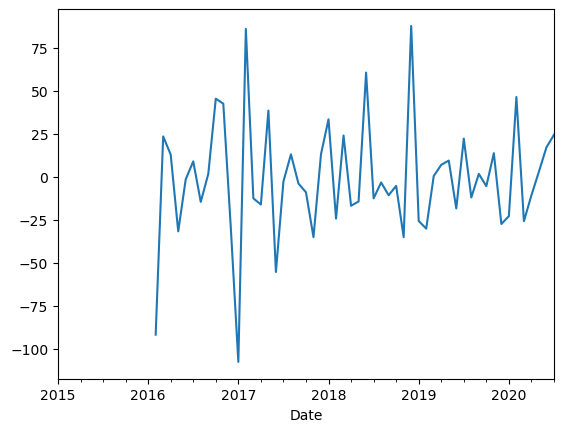

In [72]:
pm25m_sdiff = pm25m_diff1 - pm25m_diff1.shift(12)
pm25m_sdiff.plot()

#### ACF and PACF plot after seasonal differencing

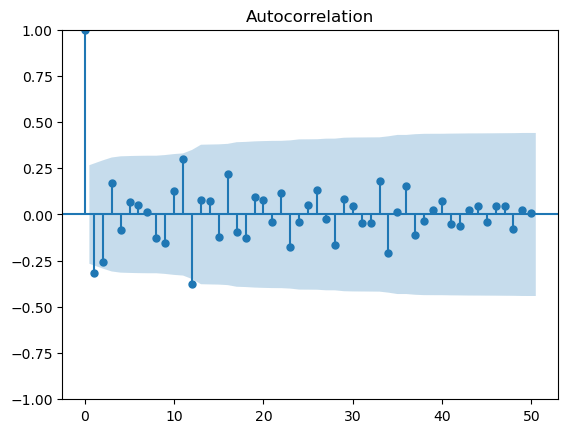

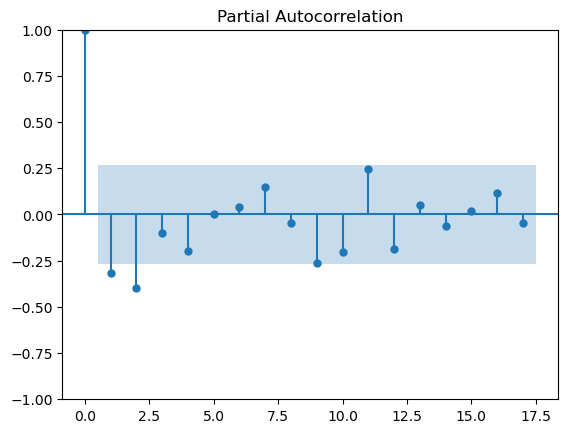

In [77]:
pm25m_sdiff_acf = plot_acf(pm25m_sdiff.dropna(), lags = 50)
pm25m_sdiff_pacf = plot_pacf(pm25m_sdiff.dropna(), lags = 17)

From the ACF and PACF plot we should take values of p,q and P,Q as -\
**p = 1,2**\
**q = 1,2**\
**P = 0**\
**Q = 0,1**

#### Data Splitting

In [83]:
train_pm25m = pm25m[pm25m.index < '2019-01-01']
test_pm25m = pm25m[pm25m.index >= '2019-01-01']

#### Model Fitting

In [86]:
orders = [(1,1,1), (1,1,2), (2,1,1), (2,1,2)]
seasonal_orders = [(0,1,0,12), (0,1,1,12)]

In [88]:
for order in orders:
    for seasonal_order in seasonal_orders:
        model = SARIMAX(train_pm25m, order = order, seasonal_order = seasonal_order).fit()

        predicted = model.predict(start = '2019-01-01', end = test_pm25m.index[-1])
        actual = test_pm25m
        rmse = ((actual - predicted)**2).mean()**0.5
        mae = abs(actual - predicted).mean()
        print('{}{}: AIC = {}, BIC = {}, LLF = {}, MAE = {}, RMSE = {}'.format(order, seasonal_order, model.aic, model.bic, model.llf,
                                                                                               mae, rmse))

(1, 1, 1)(0, 1, 0, 12): AIC = 350.71441011921627, BIC = 355.38045430368453, LLF = -172.35720505960813, MAE = 13.783739308949135, RMSE = 16.83077378271882
(1, 1, 1)(0, 1, 1, 12): AIC = 340.6853581957597, BIC = 346.90675044171735, LLF = -166.34267909787985, MAE = 18.53866191616136, RMSE = 23.266918136208744
(1, 1, 2)(0, 1, 0, 12): AIC = 350.91267048183283, BIC = 357.1340627277905, LLF = -171.45633524091642, MAE = 14.557995963382115, RMSE = 19.955372913048063
(1, 1, 2)(0, 1, 1, 12): AIC = 342.5982920790851, BIC = 350.3750323865322, LLF = -166.29914603954256, MAE = 18.646966966577708, RMSE = 23.73927651224552
(2, 1, 1)(0, 1, 0, 12): AIC = 351.8736596983498, BIC = 358.09505194430744, LLF = -171.9368298491749, MAE = 14.680252170184067, RMSE = 19.12832515133312
(2, 1, 1)(0, 1, 1, 12): AIC = 342.33168907874636, BIC = 350.10842938619345, LLF = -166.16584453937318, MAE = 18.22831850608672, RMSE = 23.33102106996987
(2, 1, 2)(0, 1, 0, 12): AIC = 352.4793623427092, BIC = 360.25610265015627, LLF = -

After checking all the metrices for fitiing and prediction accuracy we observe that the AIC/BIC doesn't change to much with varying orders same with the Log Likelihood but the MAE and RMSE are lower with the most simple order. So we choose the simpler model that is SARIMAX(1,1,1)(0,1,0,12)



In [91]:
pm25m_model = SARIMAX(train_pm25m, order = (1,1,1), seasonal_order = (0,1,0,12)).fit()
print(pm25m_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               PM2.5   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -172.357
Date:                             Tue, 13 May 2025   AIC                            350.714
Time:                                     00:21:19   BIC                            355.380
Sample:                                 01-01-2015   HQIC                           352.325
                                      - 12-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0458      0.247      0.185      0.853      -0.439       0.531
ma.L1         -0.8296      

#### Residuals

<Axes: title={'center': 'Density of residuals'}, ylabel='Density'>

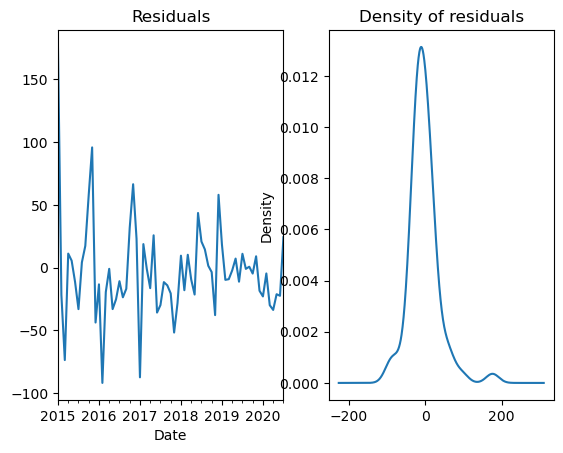

In [94]:
pm25m_res = pm25m - pm25m_model.predict(start = pm25m.index[0], end = pm25m.index[-1])
fig, ax = plt.subplots(1,2)
pm25m_res.plot(title = 'Residuals', ax = ax[0])
pm25m_res.plot(title = 'Density of residuals', kind = 'kde', ax = ax[1])

#### ACF and PACF plot of residuals

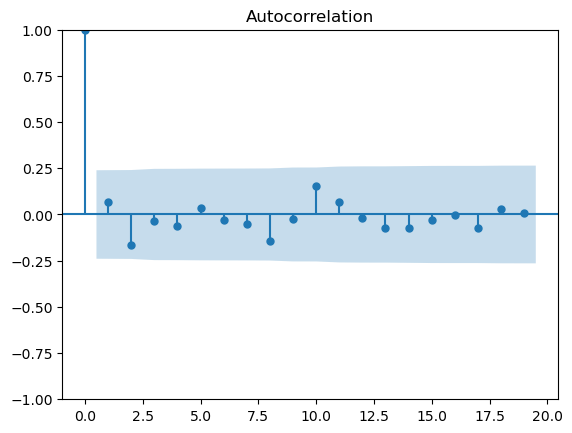

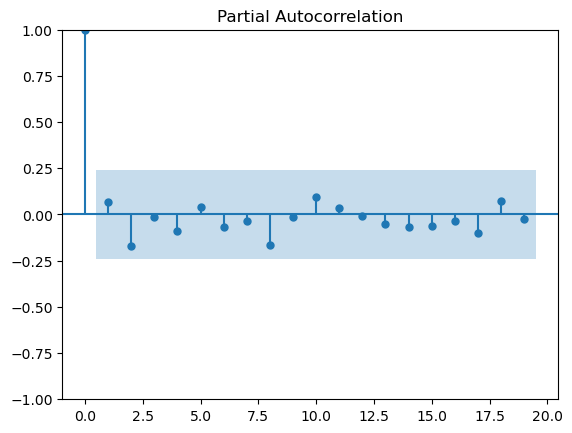

In [97]:
pm25m_res_acf = plot_acf(pm25m_res)
pm25m_res_pacf = plot_pacf(pm25m_res)

The density plot of the residuals shows that the residuals are random and normaly distributed around 0, also from the ACF and PACF plot it is clear that the residuals are completely uncorrelated indicating that the assumptions of the model are not violated and our model has captured most of the components and patterns from the data.

#### Forecasting and Comparing

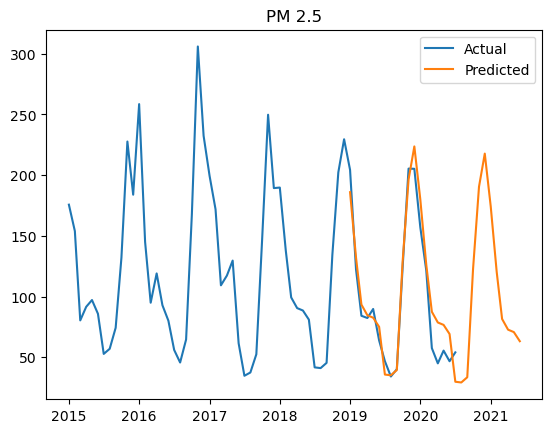

In [101]:
plt.plot(pm25m, label = 'Actual')
plt.plot(pm25m_model.forecast(steps = 30), label = 'Predicted')
plt.title('PM 2.5')
plt.legend()